In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from torchvision.datasets import utils
import torch.utils.data as data_utils
import torch
import os
import numpy as np
from torch import nn
from torch.nn.modules import upsampling
from torch.functional import F
from torch.optim import Adam
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset

MINIBATCH=32

In [4]:
# Use the GPU if you have one
if torch.cuda.is_available():
  print("Using the GPU")
  device = torch.device("cuda") 
else:
  print("WARNING: You are about to run on cpu, and this will likely run out \
       of memory. \n You can try setting batch_size=1 to reduce memory usage")
  device = torch.device("cpu")

Using the GPU


In [0]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
  trainvalid = torchvision.datasets.SVHN(
    dataset_location, split='train',
    download=True,
    transform=image_transform
  )

  trainset_size = int(len(trainvalid) * 0.9)
  trainset, validset = dataset.random_split(
    trainvalid,
    [trainset_size, len(trainvalid) - trainset_size]
  )

  trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
  )

  validloader = torch.utils.data.DataLoader(
    validset,
    batch_size=batch_size,
  )

  testloader = torch.utils.data.DataLoader(
    torchvision.datasets.SVHN(
      dataset_location, split='test',
      download=True,
      transform=image_transform
    ),
      batch_size=batch_size,
  )
    
  return trainloader, validloader, testloader

In [6]:
train, valid, test = get_data_loader("svhn", MINIBATCH)

0it [00:00, ?it/s]

 99%|█████████▉| 181067776/182040794 [00:12<00:00, 21237218.43it/s]
0it [00:00, ?it/s]


 98%|█████████▊| 62734336/64275384 [00:07<00:00, 20709796.28it/s]

In [0]:
def showImg(img):
  image = np.squeeze(img.data.numpy())
#   image = (image - np.min(image)) / (np.max(image) - np.min(image))
  image=image*0.5+0.5
  image = image.transpose((1, 2, 0))
  plt.imshow(image)
  plt.show()

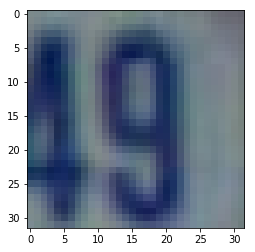

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
for x in valid:
    showImg(x[0][0])
    break


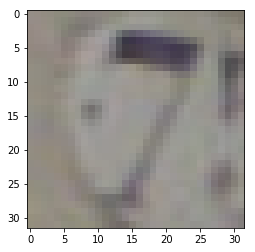

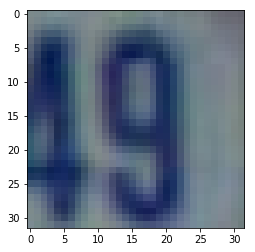

In [9]:
showImg(x[0][1].cpu())
showImg(x[0][0].cpu())


VAE

In [0]:

class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class unFlatten(nn.Module):
  def forward(self, input):
    return input.view(-1, 512, 1, 1)

class VAE(nn.Module):
  def __init__(self, latent):
    super(VAE, self).__init__()
    self.latent=latent
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, 3),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(32, 64, 3),
      nn.BatchNorm2d(64),
      nn.ELU(),
      nn.AvgPool2d(2, stride=2),
      nn.Conv2d(64, 256, 5),
      nn.BatchNorm2d(256),
      nn.ELU(),
      nn.Conv2d(256,512,2),
      nn.BatchNorm2d(512),
      nn.ELU(),
      Flatten(),
      nn.Linear(512,2*self.latent),
    )

    self.decoder = nn.Sequential(
      nn.Linear(self.latent, 512),
      unFlatten(),
      nn.BatchNorm2d(512),
      nn.ELU(),
      nn.Conv2d(512, 128, 5,padding=4),
      nn.BatchNorm2d(128),
      nn.ELU(),
      nn.Upsample(scale_factor=2, mode='bilinear'),
      nn.Conv2d(128, 64, 3, padding=2),
      nn.BatchNorm2d(64),
      nn.ELU(),
      nn.Upsample(scale_factor=2, mode='bilinear'),
      nn.Conv2d(64, 32, 3,padding=2),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.Conv2d(32,16,3,padding=2),
      nn.BatchNorm2d(16),
      nn.ELU(),
      nn.Conv2d(16,3,3,padding=3),
      nn.BatchNorm2d(3),
      nn.Tanh(),
    )
               
 
  def encode(self, x):
    return self.encoder(x)

  def reparameterize(self,MB):
    self.mu,self.log_sigma=self.latent_params[:,:self.latent],self.latent_params[:,self.latent:]
    sigma =torch.exp(self.log_sigma)+1e-7
    e=torch.randn(MB,self.latent).to(device)
    z = self.mu+sigma*e
    return z
    
  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    self.latent_params=self.encode(x)
    z=self.reparameterize(x.size()[0])
    x_reconst = self.decode(z)
    return x_reconst, self.mu, self.log_sigma
      


In [0]:
class Flatten2(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class unFlatten2(nn.Module):
  def forward(self, input):
    return input.view(-1, 128*4, 4, 4)

class VAE2(nn.Module):
  def __init__(self, latent):
    super(VAE2, self).__init__()
    self.latent=latent
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 128, 2, stride=2), # MB 128 16 16
      nn.BatchNorm2d(128), # MB 128 16 16
      nn.ELU(), # MB 128 16 16
      nn.Conv2d(128, 128*2, 2, stride=2), # MB 256 8 8 
      nn.BatchNorm2d(128*2), # MB 256 8 8
      nn.ELU(), # MB 256 8 8
      nn.Conv2d(128*2, 128*4, 2, stride=2), # MB 512 4 4
      nn.BatchNorm2d(128*4), # MB 512 4 4 
      nn.ELU(), # MB 512 4 4 
      Flatten2(),
      nn.Linear(128*4*4*4,2*self.latent),
    )

    self.decoder = nn.Sequential(
      nn.Linear(self.latent, 128*4*4*4),
      unFlatten2(),
      nn.ConvTranspose2d(128*4,128*4,2,stride=2), # MB 512 2 2 
      nn.BatchNorm2d(128*4),
      nn.ELU(),
      nn.ConvTranspose2d(128*4, 128*2, 2,stride=2), # MB 256 4 4
      nn.BatchNorm2d(128*2),
      nn.ELU(),
      nn.ConvTranspose2d(128*2, 128, 2, stride=2), #MB 128 8 8
      nn.BatchNorm2d(128),
      nn.ELU(),
      nn.Conv2d(128, 3, 1),
      nn.Tanh(),
    )
               
 
  def encode(self, x):
    return self.encoder(x)

  def reparameterize(self,MB):
    self.mu,self.log_sigma=self.latent_params[:,:self.latent],self.latent_params[:,self.latent:]
    sigma =torch.exp(self.log_sigma)+1e-7
    e=torch.randn(MB,self.latent).to(device)
    z = self.mu+sigma*e
    return z
    
  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    self.latent_params=self.encode(x)
    z=self.reparameterize(x.size()[0])
    x_reconst = self.decode(z)
    return x_reconst, self.mu, self.log_sigma
      


In [0]:
class Flatten3(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class unFlatten3(nn.Module):
  def forward(self, input):
    return input.view(-1, 512, 4, 4)

class VAE3(nn.Module):
  def __init__(self, latent):
    super(VAE3, self).__init__()
    self.latent=latent
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, 3),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.Conv2d(32,32,2, stride=2),
      nn.Conv2d(32, 64, 3),
      nn.BatchNorm2d(64),
      nn.ELU(),
      nn.Conv2d(64,64,2, stride=2),
      nn.Conv2d(64, 256, 5),
      nn.BatchNorm2d(256),
      nn.ELU(),
      nn.Conv2d(256,512,2),
      nn.BatchNorm2d(512),
      nn.ELU(),
      Flatten3(),
      nn.Linear(512,2*self.latent),
    )

    self.decoder = nn.Sequential(
      nn.Linear(self.latent, 512*4*4),
      unFlatten3(),
      nn.ConvTranspose2d(512, 128, 3,padding=2),
      nn.BatchNorm2d(128),
      nn.ELU(),
      nn.ConvTranspose2d(128,128, 2, stride=2),
      nn.Conv2d(128, 64, 3, padding=2),
      nn.BatchNorm2d(64),
      nn.ELU(),
      nn.ConvTranspose2d(64,64,2,stride=2),
      nn.Conv2d(64, 32, 3,padding=2),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.Conv2d(32,16,3,padding=2),
      nn.BatchNorm2d(16),
      nn.ELU(),
      nn.ConvTranspose2d(16,3,2,stride=2),
      nn.Tanh(),
    )
               
 
  def encode(self, x):
    return self.encoder(x)

  def reparameterize(self,MB):
    self.mu,self.log_sigma=self.latent_params[:,:self.latent],self.latent_params[:,self.latent:]
    sigma =torch.exp(self.log_sigma)+1e-7
    e=torch.randn(MB,self.latent).to(device)
    z = self.mu+sigma*e
    return z
    
  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    self.latent_params=self.encode(x)
    z=self.reparameterize(x.size()[0])
    x_reconst = self.decode(z)
    return x_reconst, self.mu, self.log_sigma

In [0]:

def ELBO(x, x_reconst, mu, log_sigma):
  kl = 0.5 * (-1. -2*log_sigma + mu**2.0+ torch.exp(log_sigma)**2.0).sum(dim=1)
  reconL =-(((x-x_reconst)**2).view(-1,3*32*32).sum(dim=1))
  return -(reconL - kl).mean()

In [0]:
e=torch.randn(3,100).to(device)

In [11]:
model = VAE2(100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
n_epochs=50

dataloader = {'Train': train, 'Valid': valid}

for epoch in range(n_epochs):
  print('Training epoch {} of {}'.format(epoch+1,n_epochs))
  for loader in ['Train', 'Valid']:
    accumulated_loss = 0
    print('Phase {}\n'.format(loader))
    if loader == 'Train':
      model.train()
    else:
      model.eval()
    
    iteration=0
    total_iterations=0.1*len(dataloader[loader].dataset)
    total_loss=0
    for data in dataloader[loader]:
      
      optimizer.zero_grad()
      x = data[0].to(device)
      x_reconst, mu, log_sigma=model(x)
      
      loss =ELBO(x, x_reconst, mu, log_sigma)
      if loader == 'Train':
        loss.backward()
        optimizer.step()
      if iteration*MINIBATCH>=total_iterations:
        print('{:.1f} % of {} phase computed, ELBO : {}'.format(np.round(iteration*MINIBATCH/len(dataloader[loader].dataset)*100,0),loader,-loss.cpu().data.numpy()))
        total_iterations=total_iterations+0.1*len(dataloader[loader].dataset)
      total_loss=(total_loss*iteration+loss.cpu().data.numpy())/(iteration+1)
      iteration=iteration+1
    print("Epoch {} ,Average {} ELBO: {:.6f}\n".format(epoch+1,loader,-total_loss))
    if loader == 'Valid':
      print('Real:\n')
      showImg(x[1].cpu())
      print('Reconstruction:\n')
      showImg(x_reconst[1].cpu())
      print('Generated:\n')
      test=model.decoder(e)
      for t in test:
        showImg(t.cpu())
        
torch.save(model.state_dict(), '/content/gdrive/My Drive/VAE.params')

NameError: ignored

# GAN

In [0]:
class FlattenD(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.classifier=nn.Sequential(
            nn.Conv2d(3,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,2,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,2,padding=1,stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,256,2,stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            FlattenD(),
            nn.Linear(256*4*4,500),
            nn.ReLU(),
            nn.Linear(500,1),
#             nn.Sigmoid(),
          )
    
    def forward(self, x):
      return self.classifier(x)


In [0]:
class unFlattenD(nn.Module):
  def forward(self, input):
    return input.view(-1, 128*4, 4, 4)

class Decoder(nn.Module):
  def __init__(self,latent):
    super(Decoder,self).__init__()
    self.latent=latent
    self.decoder = nn.Sequential(
      nn.Linear(self.latent, 128*4*4*4),
      unFlattenD(),
      nn.ConvTranspose2d(128*4,128*4,2,stride=2), # MB 512 2 2 
      nn.BatchNorm2d(128*4),
      nn.ELU(),
      nn.ConvTranspose2d(128*4, 128*2, 2,stride=2), # MB 256 4 4
      nn.BatchNorm2d(128*2),
      nn.ELU(),
      nn.ConvTranspose2d(128*2, 128, 2, stride=2), #MB 128 8 8
      nn.BatchNorm2d(128),
      nn.ELU(),
      nn.Conv2d(128, 3, 1),
      nn.Tanh(),
    )
    
  def forward(self,x):
    return self.decoder(x)
 

In [0]:
def noise(MB,latent):
  return torch.randn(MB,latent).to(device)

def JSD(Dx,Dy):
  return np.log(2) + 0.5 * torch.mean(torch.log(Dx)) + 0.5 * torch.mean(torch.log(1 - Dy))

def LossG(Dy):
  return torch.log(Dy).mean()

def WD(Tx,Ty,GP,lam):
  return Tx.mean()-Ty.mean()-lam*GP

def GP_func(C,x,y):
  a=torch.FloatTensor(np.random.uniform(0, 1, (x.size(0), 1))).to(device).expand((x.view(-1,3*32*32)).size())
#   print(x.view(-1,3*3*32).size())
  z=(a*x.view(-1,3*32*32)+(1-a)*y.view(-1,3*32*32)).view(-1,3,32,32)
  z= torch.autograd.Variable(z, requires_grad=True)
  Tz=C(z)
  gradients = torch.autograd.grad(Tz,z,grad_outputs= torch.ones(Tz.size()).to(device),create_graph=True, retain_graph=True, only_inputs=True)
#   print(gradients[0].view(-1,3*32*32).size())
#   print(((gradients[0].view(-1,3*32*32).norm(2, dim=1)-1)**2).mean())
  return ((gradients[0].view(-1,3*32*32).norm(2, dim=1)-1)**2).mean()
  

In [0]:
L=100
import copy

D = Discriminator().to(device)
G = Decoder(L).to(device)
# G.decoder=copy.deepcopy(model.decoder)
optimizer_D = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizer_G = torch.optim.Adam(G.parameters(), lr=0.0002)

lam=25
  
dataloader = {'Train': train, 'Valid': valid}

n_total_it=200000
total_iterations=0
n_iter_D=2
it_D=0
total_loss_D=0
total_loss_G=0
total_it_D=0
total_it_G=0
while total_iterations<=n_total_it:
  for loader in ['Train', 'Valid']:
    print('Data from {}\n'.format(loader))
    
    for data in dataloader[loader]:
      
      #----Discriminator-----
      
      optimizer_D.zero_grad()
      x = data[0].to(device)
      gy=noise(x.size(0),L)
      y=G(gy)
      GP=GP_func(D,x,y)
      optimizer_D.zero_grad()
      Tx=D(x)
      Ty=D(y)
      loss_D=-WD(Tx,Ty,GP,lam)
      loss_D.backward()
      optimizer_D.step()
      
      it_D=it_D+1
      total_loss_D=(total_loss_D*total_it_D+loss_D.cpu().data.numpy())/(total_it_D+1)
      total_it_D=total_it_D+1
      
#       print('Epoch {}, D it: {}, JSD {}'.format(epoch+1,it_D,-loss_D.cpu().data.numpy()))
        
      if it_D == n_iter_D:
        it_D=0
        #--------Generator-----------
        optimizer_G.zero_grad()
        gy=noise(x.size(0),L)
        y=G(gy)
        Ty=D(y)
        loss_G=-Ty.mean()
        loss_G.backward()
        optimizer_G.step()
        total_loss_G=(total_loss_G*total_it_G+loss_G.cpu().data.numpy())/(total_it_G+1)
        total_it_G=total_it_G+1
        
        if total_iterations%1000==0:
          print('{} iterations, D loss : {}, G Loss: {}'.format(total_iterations,-total_loss_D,-total_loss_G))
          total_loss_D=0
          total_loss_G=0
          total_it_D=0
          total_it_G=0
          print('Real:\n')
          showImg(x[1].cpu())
          print('Generated:\n')
          test=G(e)
          for t in test:
            showImg(t.cpu()) 
        total_iterations=total_iterations+1
      
torch.save(G.state_dict(), '/content/gdrive/My Drive/GAN.params')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
V=VAE2(100).to(device)
V.load_state_dict(torch.load('/content/gdrive/My Drive/VAE.params'))
G=Decoder(100).to(device)
G.load_state_dict(torch.load('/content/gdrive/My Drive/GAN.params'))



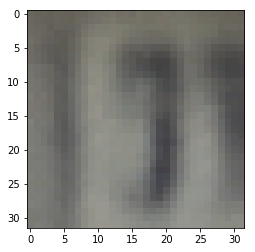

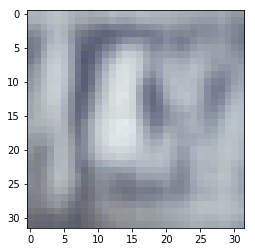

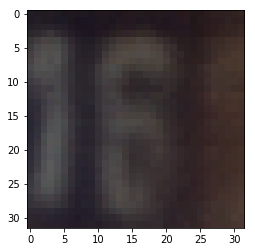

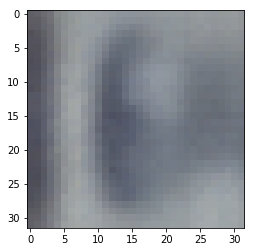

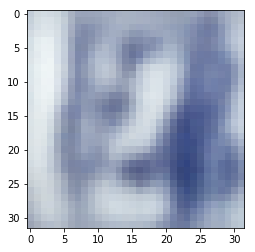

In [63]:
#e=noise(5,100)
test=V.decoder(e)
for t in test:
  showImg(t.cpu())

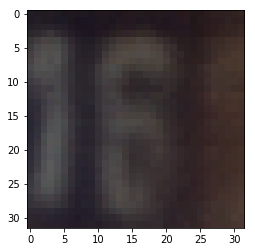

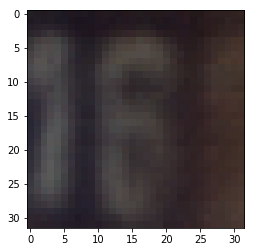

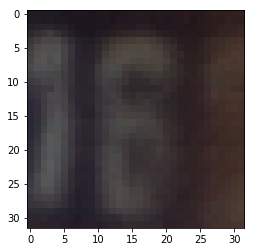

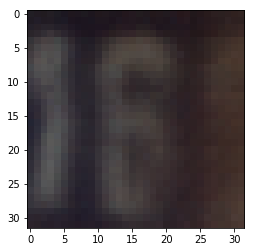

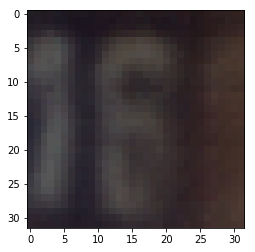

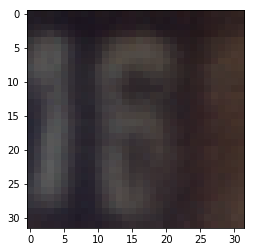

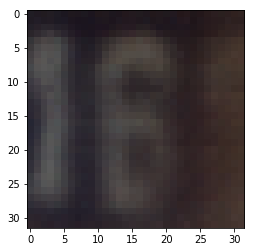

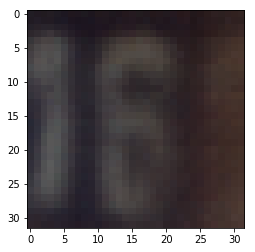

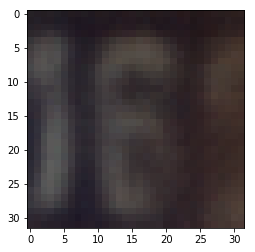

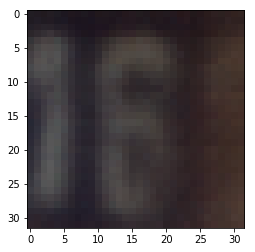

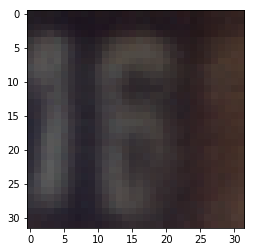

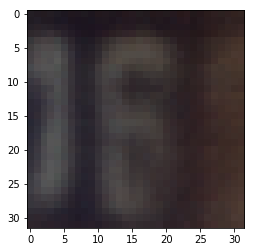

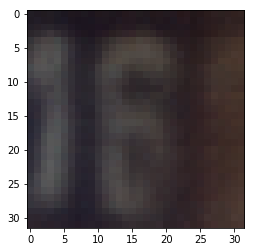

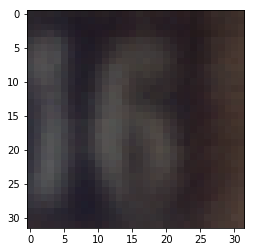

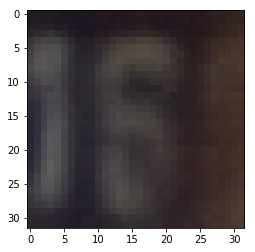

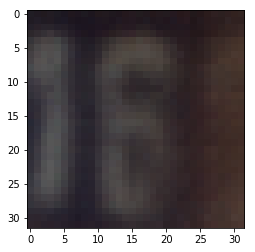

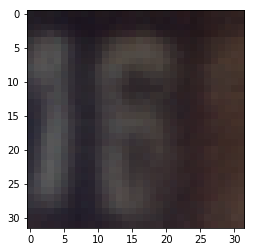

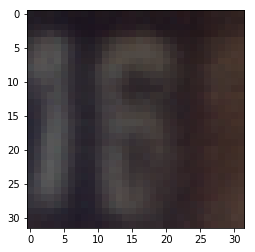

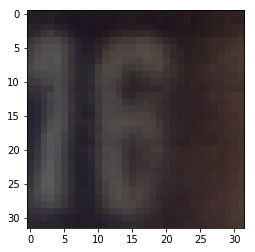

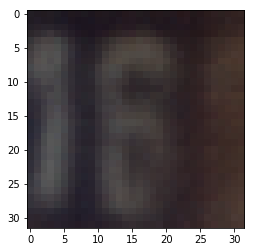

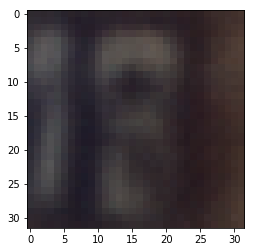

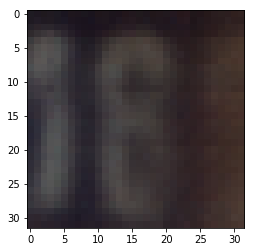

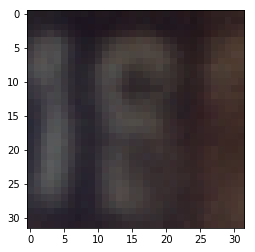

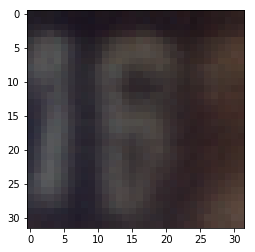

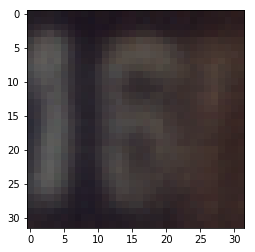

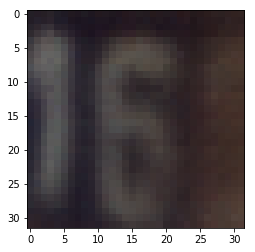

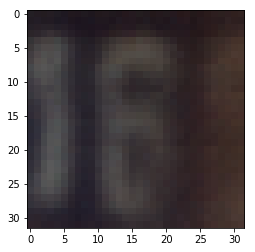

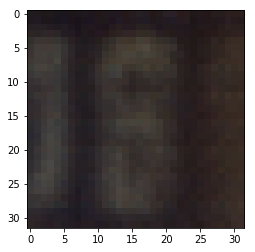

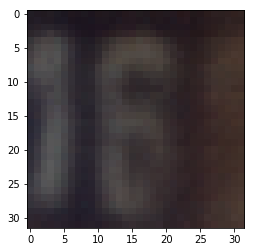

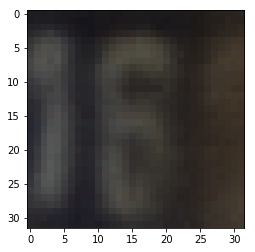

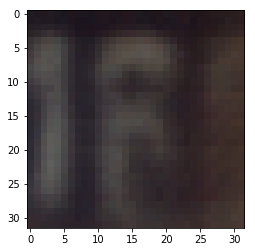

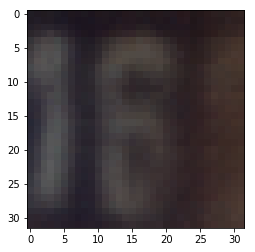

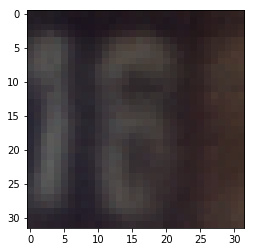

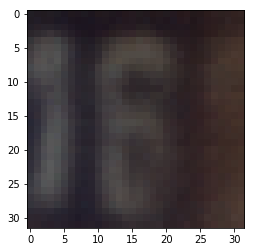

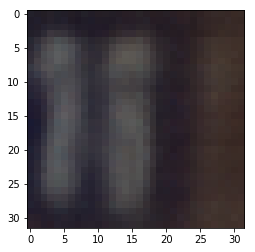

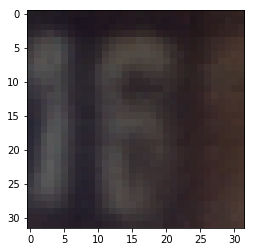

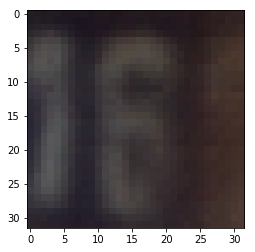

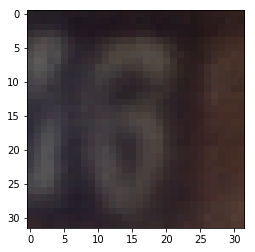

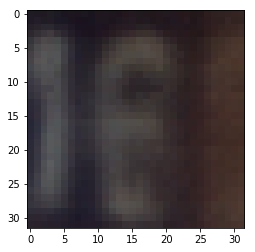

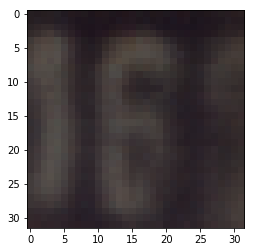

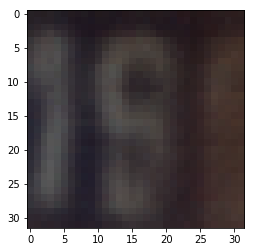

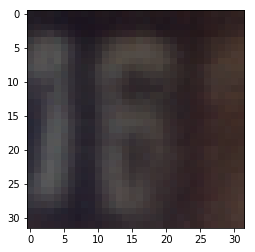

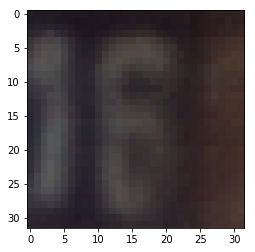

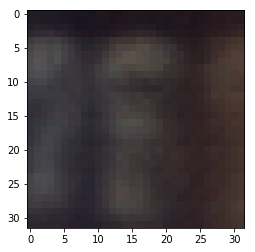

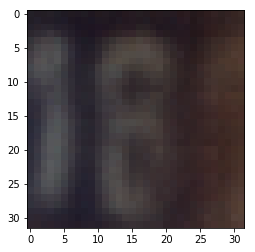

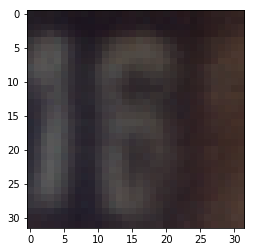

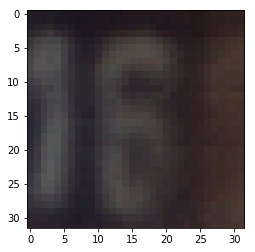

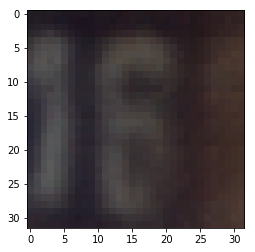

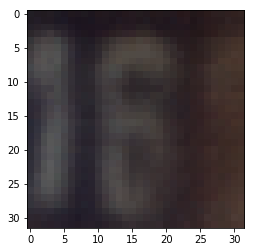

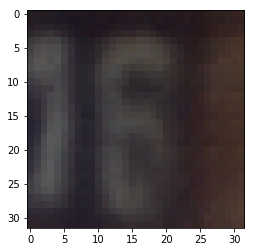

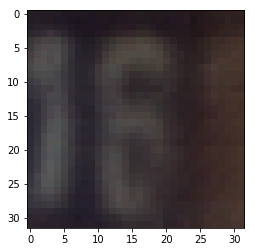

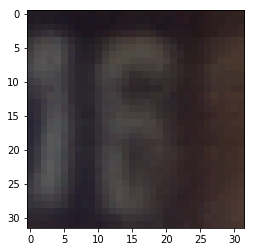

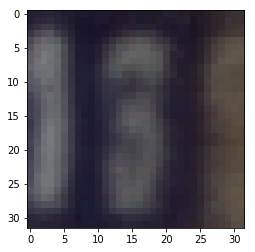

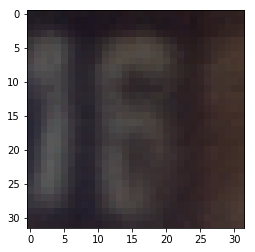

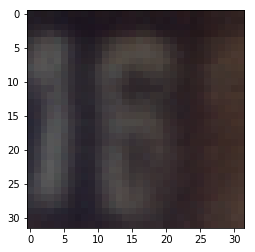

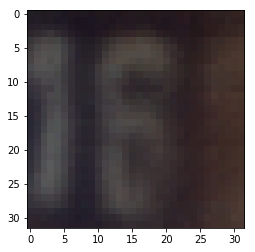

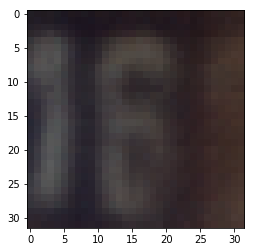

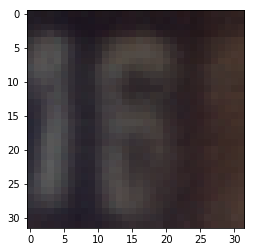

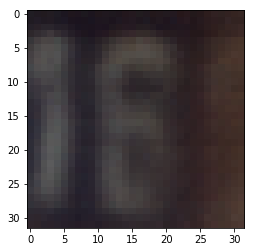

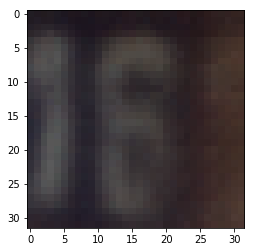

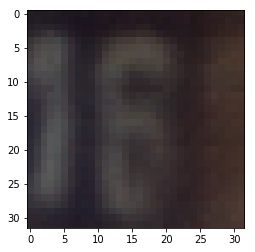

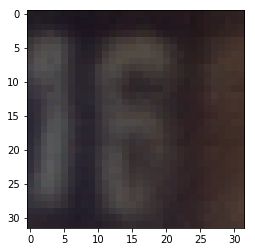

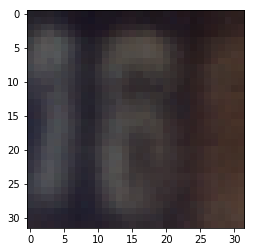

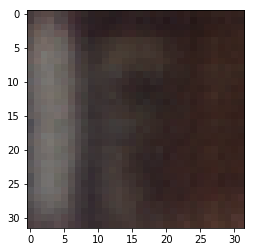

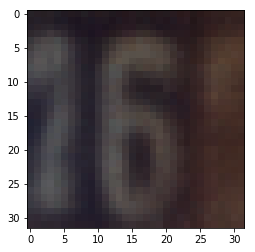

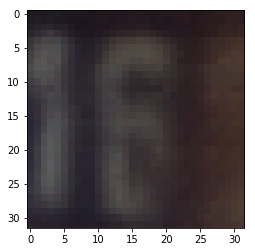

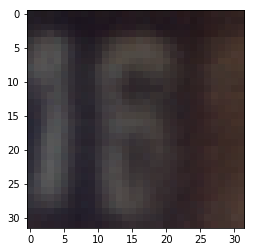

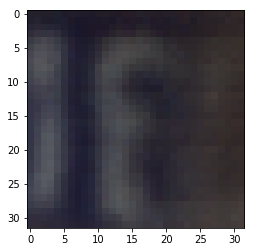

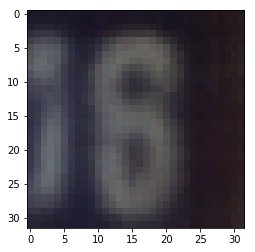

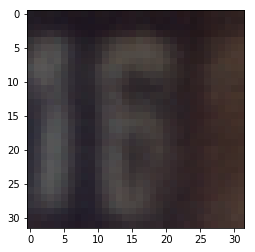

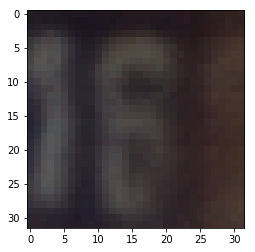

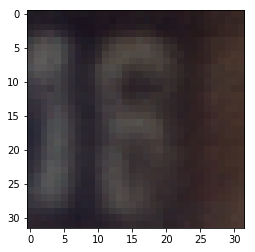

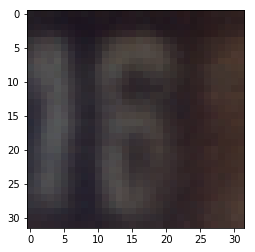

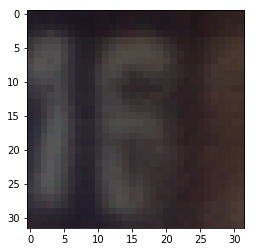

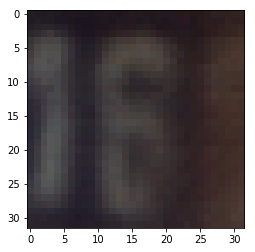

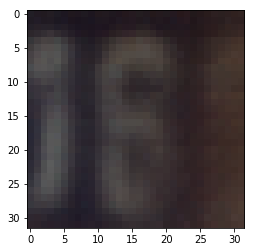

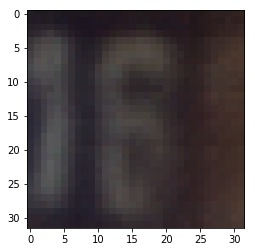

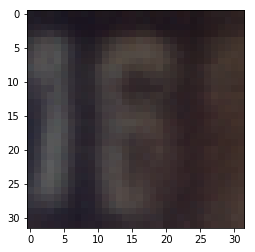

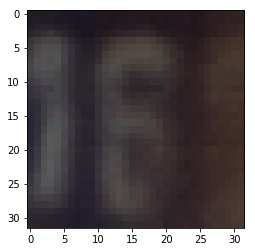

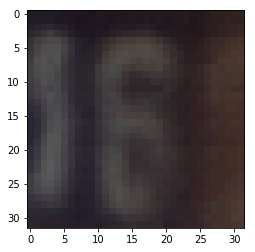

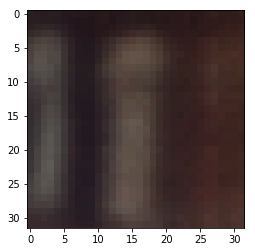

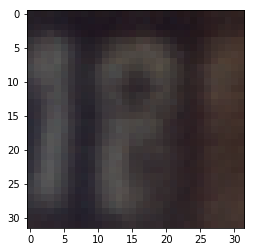

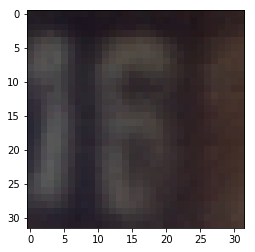

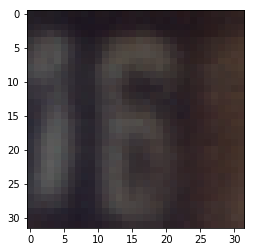

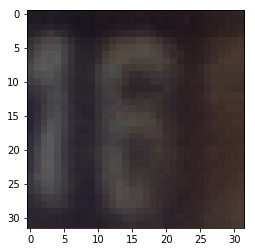

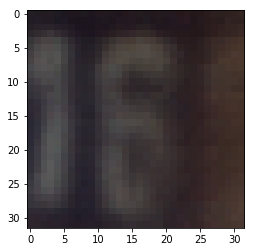

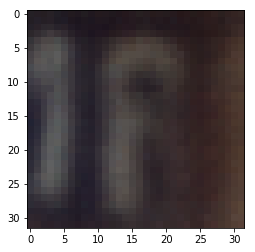

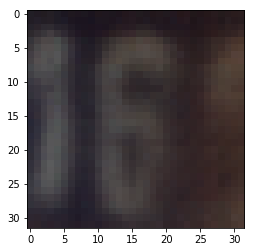

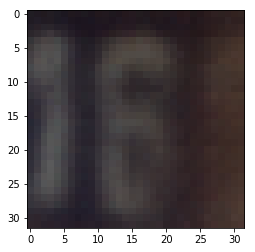

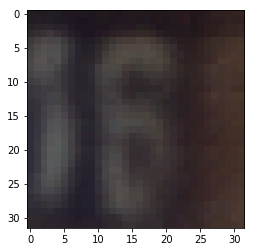

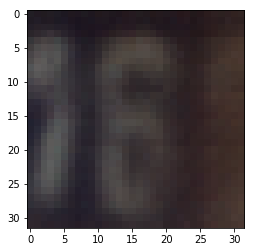

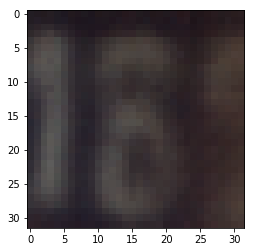

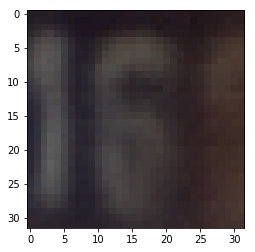

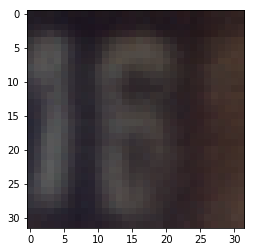

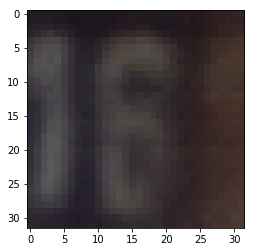

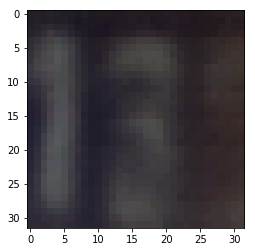

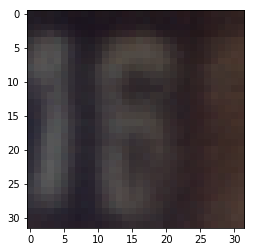

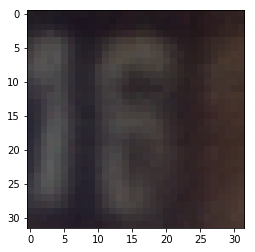

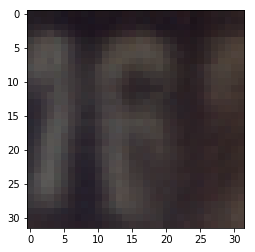

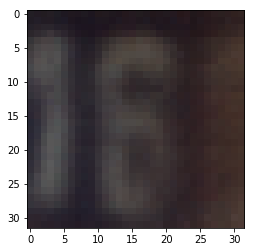

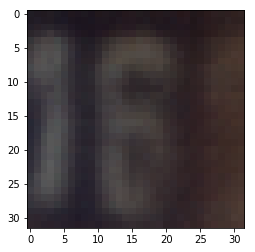

In [65]:
import PIL
import copy
# e=torch.cat((e,e))
error=2
pic=2
t=V.decoder(e)
showImg(t[pic].cpu())
model='VAE'
image = np.squeeze(t[pic].cpu().data.numpy())
image=image*0.5+0.5
image = image.transpose((1, 2, 0))
image = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
im = PIL.Image.fromarray(image).convert('RGB')
im.save('/content/gdrive/My Drive/Qualitive_1/' + str(model) + 'original.jpeg')




for i in range(100):
  f=copy.deepcopy(e)
  f[pic,i]=f[pic,i]+error
  t=V.decoder(f)
  showImg(t[pic].cpu()) 
  image = np.squeeze(t[pic].cpu().data.numpy())
  image=image*0.5+0.5
  image = image.transpose((1, 2, 0))
  image = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
  im = PIL.Image.fromarray(image).convert('RGB')
  im.save('/content/gdrive/My Drive/Qualitive_1/' + str(model) +'_dim_' +str(i)+'.jpeg')
      

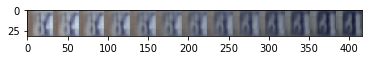

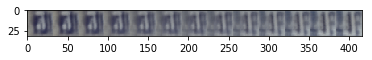

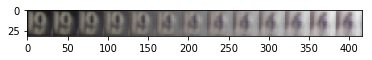

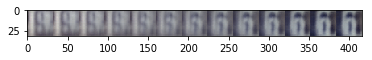

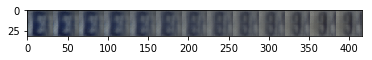

In [98]:
# z_0=noise(5,100)
# z_1=noise(5,100)
model='VAE'
Z1=V.decoder(z_0)
Z2=V.decoder(z_1)
alpha=np.round(np.linspace(0,1,11),1)
# print(alpha)
# for t in test:
#   showImg(t.cpu())
# test=V.decoder(y_0)
# for t in test:
#   showImg(t.cpu())
final=Z1
for a in alpha:
  z=a*Z2+(1-a)*Z1
#   t=G(z)
  final=torch.cat((final,z),dim=3)
final=torch.cat((final,Z2),dim=3)
count=0
for z in final:
  showImg(z.cpu())
  image = np.squeeze(z.cpu().data.numpy())
  image=image*0.5+0.5
  image = image.transpose((1, 2, 0))
  image = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
  im = PIL.Image.fromarray(image).convert('RGB')
  im.save('/content/gdrive/My Drive/Qualitive_3_b/' + str(model) +'_'+ str(count)+'.jpeg')
  count=count+1

In [90]:
Z1.size()

torch.Size([5, 3, 32, 64])

In [86]:
Z1[0]

tensor([[[ 0.4166,  0.3698,  0.3239,  ...,  0.0525,  0.0367, -0.0467],
         [ 0.4136,  0.2935,  0.1736,  ..., -0.0035, -0.0904, -0.1809],
         [ 0.3557,  0.1667, -0.0022,  ..., -0.0237, -0.0528, -0.0327],
         ...,
         [ 0.4446,  0.3246,  0.3659,  ...,  0.3881,  0.4312,  0.4446],
         [ 0.4845,  0.4718,  0.5087,  ...,  0.2303,  0.3835,  0.4415],
         [ 0.5478,  0.5641,  0.5638,  ...,  0.1556,  0.2930,  0.3831]],

        [[ 0.3907,  0.3395,  0.2895,  ..., -0.0949, -0.1162, -0.2167],
         [ 0.3362,  0.2234,  0.0672,  ..., -0.1762, -0.2376, -0.3642],
         [ 0.2645,  0.0910, -0.1307,  ..., -0.1879, -0.2610, -0.2702],
         ...,
         [ 0.4040,  0.2969,  0.3585,  ...,  0.2415,  0.2944,  0.2670],
         [ 0.4716,  0.4670,  0.5305,  ...,  0.0192,  0.0949,  0.1657],
         [ 0.5380,  0.5499,  0.5756,  ..., -0.1059, -0.0389,  0.0811]],

        [[ 0.2977,  0.2455,  0.1807,  ..., -0.2118, -0.2149, -0.2594],
         [ 0.2837,  0.1574,  0.0201,  ..., -0